In [1]:
import pandas as pd
import numpy as np
import glob
from scipy.stats import ttest_ind, ttest_1samp
import scipy
from tqdm.notebook import tqdm

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

DATADIR = '../data/' # directory that contains the anonymized data

In [2]:
cm = 1/2.54  # centimeters in inches
font = {'size': 7}
matplotlib.rc('font', **font)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['grid.linewidth'] = 0.5
matplotlib.rcParams['axes.linewidth'] = 0.5

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [3]:
def publisherNameMap(x):
    d = {
        'ieee':'IEEE',
        'pnas':'PNAS',
        'hindawi':'Hindawi',
        'mdpi':'MDPI',
        'plos':'PLOS',
        'frontiers':'Frontiers'
    }
    return d[x]

In [4]:
%%time
authors = (
    pd.read_csv(DATADIR + 'race_rep/Authors.tsv',sep='\t')
    .assign(Publisher=lambda df: df.Publisher.apply(publisherNameMap))
)

editors = (
    pd.read_csv(DATADIR + 'race_rep/Editors.tsv',sep='\t')
    .assign(Publisher=lambda df: df.Publisher.apply(publisherNameMap))
)

CPU times: user 245 ms, sys: 57.5 ms, total: 302 ms
Wall time: 303 ms


In [5]:
print(authors.shape, editors.shape) # (448851, 9) (104137, 9)

(448851, 3) (104137, 3)


In [6]:
authors.Year.min(), authors.Year.max()

(2001, 2020)

In [7]:
COLOR = {
    'White': '#377eb8',
    'API': '#4daf4a',
    'Hispanic': '#ff7f00',
    'Black': '#e41a1c'
}

# 2a

In [8]:
stdError = lambda p: np.sqrt(p[0]*(1-p[0])/p[1])*scipy.stats.t.ppf((1+0.95)/2., p[1]-1)

In [9]:
def computeBarHeight(df, race, col='Race', equal='=='):
    
    n = df.shape[0]
    if n==0: return (0, 0)
    p = df.query(f'{col} {equal} "{race}"').shape[0]/n
    
    return (p, n)

In [10]:
def barRacePlot(df, ax, races=['White', 'API', 'Hispanic', 'Black'], width=0.6):
    
    x = [x for x in range(len(races), 0, -1)]
    hn = [computeBarHeight(df, race) for race in races]
    print(hn)
    
    plt.barh(x, [p[0] for p in hn], height=width, lw=1, color=[COLOR[race] for race in races],
            yerr=[stdError(p) for p in hn],
            error_kw={'elinewidth':2})
    
    ax.set_yticks(x)
    ax.set_yticklabels(races)
    
    ax.set_xticks([0, 0.2, 0.4, 0.6])
    ax.set_xticklabels([])
    
    ax.tick_params(length=0)
    ax.grid(visible=True, ls=':', axis='x')
    
    for i in range(len(races)):
        
        ax.text(hn[i][0]+0.02, 4-i, str(round(hn[i][0]*100, 1))+'%')

[(0.5751558043730854, 104137), (0.3961512238685578, 104137), (0.027963163909081306, 104137), (0.0006913969098399224, 104137)]


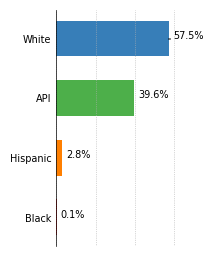

In [11]:
ax = plt.gca()

set_size(3*cm, 6*cm)

barRacePlot(editors, ax)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('../figures/figure_2a.pdf', bbox_inches = 'tight', pad_inches = 0)
# (0.5751558043730854, 104137), (0.3961512238685578, 104137)
# (0.027963163909081306, 104137), (0.0006913969098399224, 104137)

# 2b

In [12]:
def calcCI(p, n):
    p = p/100
    return np.sqrt(p*(1-p)/n)*scipy.stats.t.ppf((1+0.95)/2., n-1)

def computeTrend(fr, query = '', col='Year', colMin=2001, colMax=2020):
    # col: the column to get percentage; could be Year, or Decade etc.
    
    colMin = max(fr[col].min(), colMin)
        
    fr = fr.assign(Count = 1)
    
    total = fr.groupby(col).Count.count().reset_index()
    
    female = (
        fr.query(query)
        .groupby(col).Count.count()
        .reset_index().rename(columns={'Count':'Fcount'})
    )
    
    total = total.merge(female, on=col, how='left')
    total = total.assign(Percent = total.Fcount/total.Count*100)
    
    df = pd.DataFrame({col: [x for x in range(colMin, colMax+1)]})    
    df = df.merge(total, on=col, how='left').fillna(0).sort_values(by=col)
    
    return (df[col].values, df.Percent.values, df.Count.values)

def plotTrend(ax, x, y, n, color='green', lw=1, ls='-', marker='o', mfc='none', fill=True):
    ax.plot(x, y, color=color, lw=lw, ls=ls, marker=marker, markersize=5, mfc=mfc, mew=0.5)
    
    if fill==True:
        ci = [calcCI(y[i], n[i])*100 for i in range(len(x))]
        lo = [y[i]-ci[i] for i in range(len(x))]
        hi = [y[i]+ci[i] for i in range(len(x))]
        ax.fill_between(x, lo, hi, color=color, alpha=0.1)
    
def plotTemporal(ax, xy, lw=1, color='#e41a1c', ls='-', marker='o', mfc='none', fill=True):
    
    for i in range(len(xy)):
        plotTrend(ax, xy[i][0], xy[i][1], xy[i][2], color, lw, ls, marker, mfc, fill)

In [13]:
def styleAx(ax, ytop=None):

    ax.set_xlim(2000, 2021)
    ax.set_xticks([2000, 2005, 2010, 2015, 2020])
    
    if ytop is None:
        _, ytop = ax.get_ylim()
    ax.set_ylim(-ytop*0.05, ytop*1.05)

    ax.grid(visible=True, ls=':')
    ax.tick_params(length=0)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [14]:
def computeRelativeTrend(df, query, colMin, colMax):
    
    fourRaces = pd.DataFrame({'Race': ['White','API','Hispanic','Black']})
    allJournals = df[['Journal','Year']].drop_duplicates()
    
    journalRace = (
        fourRaces.assign(Key=1).merge(allJournals.assign(Key=1), on='Key')
    )
    
    percentage = (
        df.groupby(['Journal','Year']).Race.value_counts(normalize=True).reset_index(name='Percentage')
        .query(f'Year >= {colMin}').query(f'Year <= {colMax}')
        .merge(journalRace, on=['Journal','Race', 'Year'], how='right')
        .fillna({'Percentage':0})
        .query(query)
    )
    
    return percentage

In [15]:
def plotRace(ax, QUERY, color):
    
    editorTrend = [computeTrend(editors, query=QUERY, colMin=2001, colMax=2020)]
    authorTrend = [computeTrend(authors, query=QUERY, colMin=2001, colMax=2020)]
    
    plotTemporal(ax, editorTrend, color=color, lw=1, marker='o', mfc=color, fill=True)
    plotTemporal(ax, authorTrend, ls=':', lw=1, color=color, marker='o', mfc='none', fill=True)
    
    return editorTrend, authorTrend, authorTrend

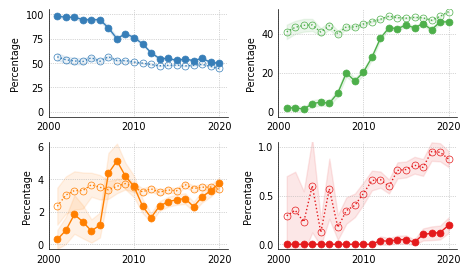

In [16]:
fig = plt.figure(figsize=(12*cm, 7*cm))

ax = plt.subplot(2, 2, 1)
e1, a1, l1 = plotRace(ax, 'Race == "White"', COLOR['White'])
styleAx(ax, ytop=100)
ax.set_xticks([2000, 2010, 2020])
ax.set_ylabel('Percentage')


ax = plt.subplot(2, 2, 2)
e2, a2, l2 = plotRace(ax, 'Race == "API"', COLOR['API'])
styleAx(ax, ytop=50)
ax.set_xticks([2000, 2010, 2020])
ax.set_ylabel('Percentage')


ax = plt.subplot(2, 2, 3)
e3, a3, l3 = plotRace(ax, 'Race == "Hispanic"', COLOR['Hispanic'])
styleAx(ax, ytop=6)
ax.set_xticks([2000, 2010, 2020])
ax.set_ylabel('Percentage')


ax = plt.subplot(2, 2, 4)
e1, a1, l1 = plotRace(ax, 'Race == "Black"', COLOR['Black'])
styleAx(ax, ytop=1)
ax.set_xticks([2000, 2010, 2020])
ax.set_yticks([0, 0.5, 1])
ax.set_ylabel('Percentage')

plt.tight_layout()

plt.savefig('../figures/figure_2b-e.pdf', bbox_inches = 'tight', pad_inches = 0)

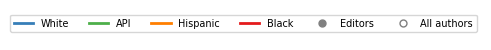

In [17]:
from matplotlib.lines import Line2D

cm = 1/2.54
legend_elements = [
    Line2D([0], [0], color=COLOR['White'], lw=2, linestyle = '-', label='White'),
    Line2D([0], [0], color=COLOR['API'], lw=2, linestyle = '-', label='API'),
    Line2D([0], [0], color=COLOR['Hispanic'], lw=2, linestyle = '-', label='Hispanic'),
    Line2D([0], [0], color=COLOR['Black'], lw=2, linestyle = '-', label='Black'),
    
    Line2D([0], [0], color='grey', marker='o', label='Editors', lw=0, markersize=5),
    Line2D([0], [0], color='grey', marker='o', label='All authors', mfc='none', lw=0, markersize=5),
]
# Line2D([0], [0], color='grey', marker='^', label='Last authors', mfc='none', lw=0, markersize=5),

fig = plt.figure(figsize=(5*cm, 1*cm))
ax = plt.gca()
ax.legend(handles=legend_elements, loc='upper right', ncol=6)
ax.set_xticks([])
ax.set_yticks([])

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('../figures/figure_2_legend.pdf',bbox_inches = 'tight', pad_inches = 0)

# 2f-2j

In [18]:
import matplotlib.patheffects as PathEffects

## 2j

In [19]:
nineteenFields = pd.read_csv(DATADIR + 'Fields.tsv', sep='\t')

In [20]:
%%time
autField = (
    pd.read_csv(DATADIR + 'race_rep/AuthorsField.tsv',sep='\t')
)

ediField = (
    pd.read_csv(DATADIR + 'race_rep/EditorsField.tsv',sep='\t')
)

CPU times: user 208 ms, sys: 53.9 ms, total: 262 ms
Wall time: 352 ms


In [21]:
def fieldRepDiff(value, key, edi=ediField, aut=autField):
    
    edi = edi.query(f'{key} == "{value}"').Race.value_counts(normalize=True).reset_index().query('index == "White"')
    aut = aut.query(f'{key} == "{value}"').Race.value_counts(normalize=True).reset_index().query('index == "White"')
    
    return round(edi.Race.values[0],3)-round(aut.Race.values[0],3)

In [22]:
def barCategoryPlot(df, ax, race, key, cats,
                    equal='==', pos=True, color='#377eb8', offset=0.05, width=0.6, showDiff=True):
    
    # only use the data in the last 10 years of observation #
    df = df.query('Year >= 2011').query('Year <= 2020')
    
    assert(df.Year.min() == 2011)
    assert(df.Year.max() == 2020)
    
    
    x = [x for x in range(len(cats), 0, -1)]
    
    hn = [computeBarHeight(df.query(f'{key} == "{cat}"'), race, equal=equal) for cat, _ in cats]
    
    if pos==False:
        ax.barh(x, [-p[0] for p in hn], height=width, lw=1, color=color, alpha=0.5)
                #yerr=[stdError(p) for p in hn],
                #error_kw={'elinewidth':2})
    else:
        ax.barh(x, [p[0] for p in hn], height=width, lw=1, color=color)
                #yerr=[stdError(p) for p in hn],
                #error_kw={'elinewidth':2})
    
    ax.set_yticks(x)
    ax.set_yticklabels([])
    
    ax.tick_params(length=0)
    #ax.grid(b=True, ls=':', axis='x')
    
    for i in range(len(cats)):
        
        if pos==True:
            ax.text(hn[i][0]+offset, len(cats)-i, str(round(hn[i][0]*100, 1))+'%', va='center')
        else:
            ax.text(-hn[i][0]-offset*1.2, len(cats)-i, str(round(hn[i][0]*100, 1))+'%', ha='right', va='center')
            
    return hn

In [24]:
fieldSeq = sorted([(field, fieldRepDiff(field, 'FieldName')) for field in nineteenFields.FieldName.unique()], key=lambda x: x[1])
fieldSeq

[('Sociology', -0.03500000000000003),
 ('Political science', -0.03200000000000003),
 ('Economics', -0.019000000000000017),
 ('Business', -0.010000000000000009),
 ('Mathematics', 0.006000000000000005),
 ('Art', 0.03300000000000003),
 ('Medicine', 0.04400000000000004),
 ('Computer science', 0.05299999999999999),
 ('Philosophy', 0.06500000000000006),
 ('History', 0.07199999999999995),
 ('Psychology', 0.07200000000000006),
 ('Biology', 0.07800000000000001),
 ('Engineering', 0.08199999999999996),
 ('Chemistry', 0.09300000000000003),
 ('Geography', 0.09499999999999997),
 ('Materials science', 0.11499999999999999),
 ('Geology', 0.12499999999999994),
 ('Physics', 0.14),
 ('Environmental science', 0.16799999999999998)]

In [25]:
def styleAx(ax, xlim, pos=True, seq=fieldSeq):
    
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position('zero')
    ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])
    ax.set_xticklabels([])

    ax.set_ylim(0.5, len(seq)+0.5)
    
    if pos: ax.set_xlim(0, xlim)
    else: ax.set_xlim(-xlim, 0)        

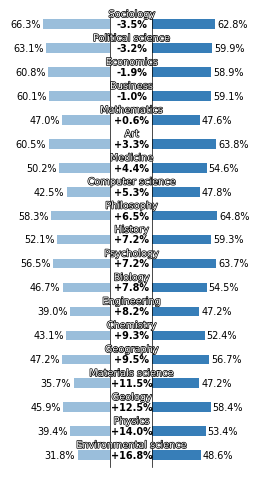

In [26]:
plt.figure(figsize=(6*cm, 15*cm))

ax = plt.subplot(1, 2, 1)
barCategoryPlot(
    autField, ax, race='White', key='FieldName', cats=fieldSeq, width=0.4,
    equal='==', color=COLOR['White'], offset=0.02, pos=False
)
styleAx(ax, xlim=0.7, pos=False)



ax = plt.subplot(1, 2, 2)

barCategoryPlot(
    ediField, ax, race='White', key='FieldName', cats=fieldSeq, width=0.4,
    equal='==', color=COLOR['White'], offset=0.02
)
styleAx(ax, xlim=0.7)


for i in range(len(fieldSeq)):
    ax.text(-0.2, len(fieldSeq)-i, '{:+.1f}%'.format(fieldSeq[i][1]*100), va='center', ha='center', weight='bold')
    
    txt = ax.text(-0.2, len(fieldSeq)-i+0.42, fieldSeq[i][0], va='center', ha='center', color='white')
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])

    
plt.subplots_adjust(wspace=0.6)


plt.savefig('../figures/figure_2j.pdf', bbox_inches = 'tight', pad_inches = 0)

## SI Figure 1

In [27]:
def plotOneRaceField(race, ax1, ax2, offset=0.02, xlim=0.7):
    
    # Global variables: editors, authors, pubSeq
    
    autHn = barCategoryPlot(
        autField, ax1, race=race, key='FieldName', cats=fieldSeq, width=0.4,
        equal='==', color=COLOR[race], offset=offset, pos=False
    )
    styleAx(ax1, xlim=xlim, pos=False)
    

    ediHn = barCategoryPlot(
        ediField, ax2, race=race, key='FieldName', cats=fieldSeq, width=0.4,
        equal='==', color=COLOR[race], offset=offset
    )
    styleAx(ax2, xlim=xlim)
    
    for i in range(len(fieldSeq)):
        ax2.text(-offset*15, len(fieldSeq)-i, '{:+.1f}%'.format((round(ediHn[i][0],3)-round(autHn[i][0],3))*100),
                 va='center', ha='center', weight='bold')

        txt = ax2.text(-offset*15, len(fieldSeq)-i+0.42, fieldSeq[i][0], va='center', ha='center', color='white')
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])


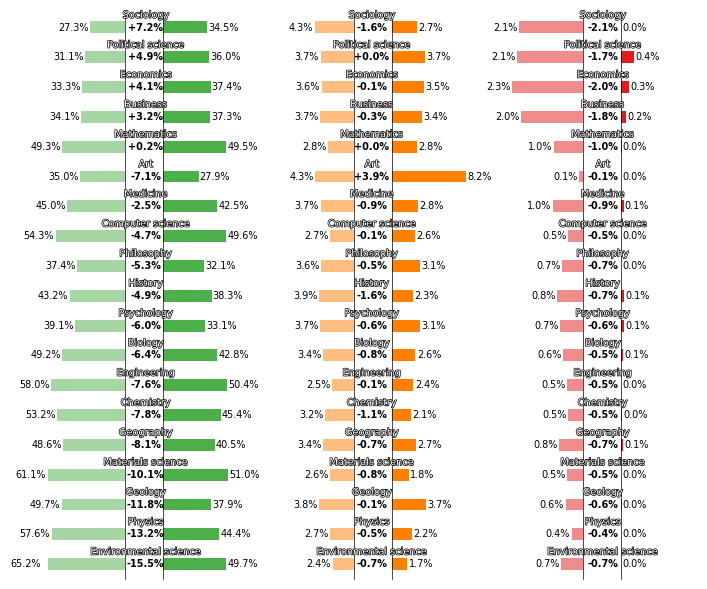

In [28]:
plt.figure(figsize=(18*cm, 15*cm))

ax1 = plt.subplot(1, 6, 1)
ax2 = plt.subplot(1, 6, 2)
plotOneRaceField('API', ax1, ax2, offset=0.009, xlim=0.6)
    
ax1 = plt.subplot(1, 6, 3)
ax2 = plt.subplot(1, 6, 4)
plotOneRaceField('Hispanic', ax1, ax2, offset=0.0015, xlim=0.085)

ax1 = plt.subplot(1, 6, 5)
ax2 = plt.subplot(1, 6, 6)
plotOneRaceField('Black', ax1, ax2, offset=0.0004, xlim=0.025)

plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

## 2f-2i

In [29]:
pubSeq = sorted([(pub,fieldRepDiff(pub, 'Publisher',
                                   edi=editors.query('Year >= 2011').query('Year <= 2020'),
                                   aut=authors.query('Year >= 2011').query('Year <= 2020')))
                 for pub in editors.Publisher.unique()], key=lambda x: x[1])

In [30]:
pubSeq

[('IEEE', -0.08299999999999999),
 ('PLOS', 0.0040000000000000036),
 ('Frontiers', 0.08899999999999997),
 ('Hindawi', 0.11600000000000005),
 ('MDPI', 0.16499999999999998),
 ('PNAS', 0.39599999999999996)]

In [31]:
def plotOneRacePublisher(race, ax1, ax2, offset=0.02, xlim=0.7):
    
    # Global variables: editors, authors, pubSeq
    
    autHn = barCategoryPlot(
        authors, ax1, race=race, key='Publisher', cats=pubSeq, width=0.4,
        equal='==', color=COLOR[race], offset=offset, pos=False
    )
    styleAx(ax1, xlim=xlim, pos=False, seq=pubSeq)
    
    ediHn = barCategoryPlot(
        editors, ax2, race=race, key='Publisher', cats=pubSeq,width=0.4,
        equal='==', color=COLOR[race], offset=offset, showDiff=False
    )
    styleAx(ax2, xlim=xlim,  seq=pubSeq)
    
    for i in range(len(pubSeq)):
        ax2.text(-offset*11, len(pubSeq)-i, '{:+.1f}%'.format((round(ediHn[i][0],3)-round(autHn[i][0],3))*100),
                 va='center', ha='center', weight='bold')

        txt = ax2.text(-offset*11, len(pubSeq)-i+0.42, pubSeq[i][0], va='center', ha='center', color='white')
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])


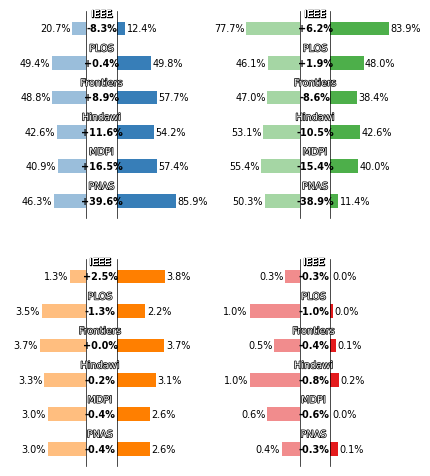

In [32]:
plt.figure(figsize=(13*cm, 15*cm))

ax1 = plt.subplot(2, 4, 1)
ax2 = plt.subplot(2, 4, 2)
plotOneRacePublisher('White', ax1, ax2, xlim=1.1)

ax1 = plt.subplot(2, 4, 3)
ax2 = plt.subplot(2, 4, 4)
plotOneRacePublisher('API', ax1, ax2, xlim=1.1)

ax1 = plt.subplot(2, 4, 5)
ax2 = plt.subplot(2, 4, 6)
plotOneRacePublisher('Hispanic', ax1, ax2, offset=0.0012, xlim=0.06)

ax1 = plt.subplot(2, 4, 7)
ax2 = plt.subplot(2, 4, 8)
plotOneRacePublisher('Black', ax1, ax2, offset=0.0003, xlim=0.015)

plt.subplots_adjust(wspace=0.4)

plt.savefig('../figures/figure_2f-i.pdf', bbox_inches = 'tight', pad_inches = 0)

## SI Figure 2

In [49]:
autTop = pd.read_csv(DATADIR + 'race_rep/AuthorsTopJournals.tsv',sep='\t')
ediTop = pd.read_csv(DATADIR + 'race_rep/EditorsTopJournals.tsv',sep='\t')

In [52]:
journalSeq = sorted([(pub,fieldRepDiff(pub, 'JournalName',
                                   edi=ediTop.query('Year >= 2011').query('Year <= 2020'),
                                   aut=autTop.query('Year >= 2011').query('Year <= 2020')))
                 for pub in ediTop.JournalName.unique()], key=lambda x: x[1])

In [53]:
journalSeq

[('IEEE Access', -0.28),
 ('PLOS One', -0.01599999999999996),
 ('Front. Microbiol.', 0.025999999999999968),
 ('Front. Immunol.', 0.11599999999999994),
 ('Int. J. Mol. Sci.', 0.322),
 ('PNAS', 0.387)]

In [55]:
def plotOneRaceJournal(race, ax1, ax2, offset=0.02, xlim=0.7):
    
    # Global variables: editors, authors, pubSeq
    
    autHn = barCategoryPlot(
        autTop, ax1, race=race, key='JournalName', cats=journalSeq, width=0.4,
        equal='==', color=COLOR[race], offset=offset, pos=False
    )
    styleAx(ax1, xlim=xlim, pos=False, seq=journalSeq)
    
    
    ediHn = barCategoryPlot(
        ediTop, ax2, race=race, key='JournalName', cats=journalSeq, width=0.4,
        equal='==', color=COLOR[race], offset=offset, showDiff=False
    )
    styleAx(ax2, xlim=xlim,  seq=journalSeq)
    
    for i in range(len(journalSeq)):
        ax2.text(-offset*11, len(journalSeq)-i, '{:+.1f}%'.format((round(ediHn[i][0],3)-round(autHn[i][0],3))*100),
                 va='center', ha='center', weight='bold')

        txt = ax2.text(-offset*10, len(journalSeq)-i+0.42, journalSeq[i][0], va='center', ha='center', color='white')
        txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])

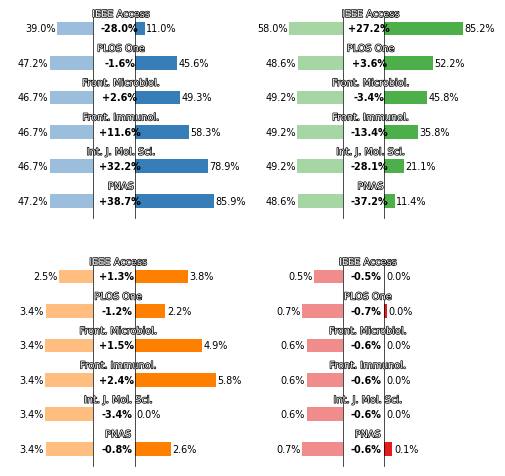

In [57]:
plt.figure(figsize=(15*cm, 15*cm))

ax1 = plt.subplot(2, 4, 1)
ax2 = plt.subplot(2, 4, 2)
plotOneRaceJournal('White', ax1, ax2, offset=0.015, xlim=0.9)

ax1 = plt.subplot(2, 4, 3)
ax2 = plt.subplot(2, 4, 4)
plotOneRaceJournal('API', ax1, ax2, offset=0.015, xlim=0.9)

ax1 = plt.subplot(2, 4, 5)
ax2 = plt.subplot(2, 4, 6)
plotOneRaceJournal('Hispanic', ax1, ax2, offset=0.0012, xlim=0.06)

ax1 = plt.subplot(2, 4, 7)
ax2 = plt.subplot(2, 4, 8)
plotOneRaceJournal('Black', ax1, ax2, offset=0.0003, xlim=0.015)

plt.subplots_adjust(wspace=0.5)